# Analysis of Utility of IPUMS data.

In [1]:
import itertools

import matplotlib.pyplot as plt

from scipy.spatial import KDTree

from statsmodels.discrete.discrete_model import Logit
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

from helper_functions import *

In [2]:
train_data = pd.read_csv("../Data/IPUMS/cleaned_ipums_data.csv")

In [3]:
sXs_mnl = [pd.read_csv("../Data/IPUMS/Synthetic Datasets/gmm_and_mnl_" + str(i) + ".csv") for i in range(20)]
# ad_sXs_mnl = [pd.read_csv("../Data/SK/Synthetic Datasets/ad_gmm_and_mnl_" + str(i) + ".csv") for i in range(20)]

sXs_cart = [pd.read_csv("../Data/IPUMS/Synthetic Datasets/gmm_and_cart_" + str(i) + ".csv") for i in range(20)]
# ad_sXs_cart = [pd.read_csv("../Data/SK/Synthetic Datasets/ad_gmm_and_cart_" + str(i) + ".csv") for i in range(20)]

sXs_mostly = [pd.read_csv("../Data/IPUMS/Synthetic Datasets/mostly_" + str(i) + ".csv") for i in range(20)]

***

## Utility Measure 1 - pMSE Ratios

In [4]:
ratios_mnl = [pmse_ratio(train_data, Y) for Y in sXs_mnl]
print(np.mean(ratios_mnl))

# ratios_ad_mnl = [pmse_ratio(train_data, Y) for Y in ad_sXs_mnl]
# print(np.mean(ratios_ad_mnl))

ratios_cart = [pmse_ratio(train_data, Y) for Y in sXs_cart]
print(np.mean(ratios_cart))

# ratios_ad_cart = [pmse_ratio(train_data, Y) for Y in ad_sXs_cart]
# print(np.mean(ratios_ad_cart))

ratios_mostly = [pmse_ratio(train_data, Y) for Y in sXs_mostly]
np.mean(ratios_mostly)

4.418156334754545
4.831668189066503


26.828970587209113

***

Save data for plotting in R.

In [5]:
pmse_results = pd.DataFrame({'Dataset': np.arange(1, len(ratios_mnl)+1),
                             'MNL': ratios_mnl,
                             # 'AD-MNL': ratios_ad_mnl,
                             'CART': ratios_cart,
                             # 'AD-CART': ratios_ad_cart,
                             'MOSTLY.AI': ratios_mostly})

pmse_results = pmse_results.melt(id_vars=["Dataset"], value_vars=["MNL", "CART", "MOSTLY.AI"], var_name="Type")
pmse_results.to_csv('../Results/IPUMS/pmse_metrics.csv', index=False)

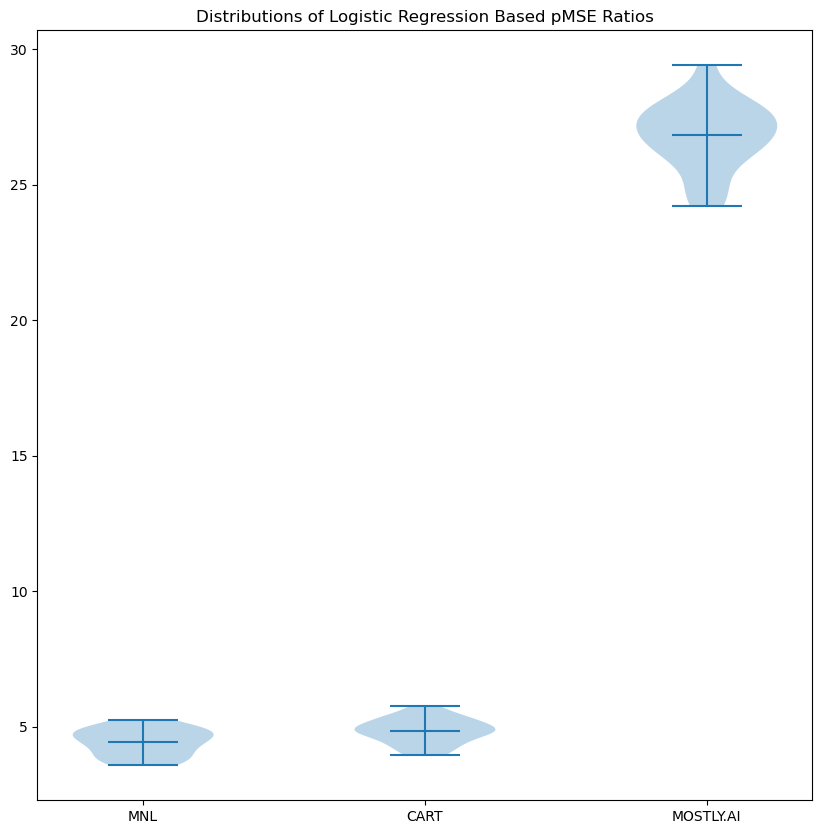

In [6]:
# Combine data
# plot_data = list([ratios_mnl, ratios_ad_mnl, ratios_cart, ratios_ad_cart, ratios_mostly])

plot_data = list([ratios_mnl, ratios_cart, ratios_mostly])

fig, ax = plt.subplots(figsize=(10,10))

# xticklabels = ["MNL", "AD-MNL", "CART", "AD-CART", "MOSTLY.AI"]
xticklabels = ["MNL", "CART", "MOSTLY.AI"]
# ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(xticklabels)

ax.violinplot(plot_data, showmeans=True)

plt.title("Distributions of Logistic Regression Based pMSE Ratios")

plt.show()

***

# Utility Metric: Analysis Specific Utility

###  * L1 distance between confidential and synthetic coefficient estimates
###  * Confidence interval ratio
###  * Sign, Significance, and Overlap (SSO)

Analysis specific utility.

Use logistic regression to predict COVID-19 deaths based on latitude and longitude, age, and sex.

Compute the model for the original data.

***

Annual earnings as a function of years_of_educ, non_white, and potential experience (up to third degree polynomial).

Do the above regression for males and females separately.

This notebook uses the normalized data.

In [7]:
train_data

,incwage,years_of_educ,potential_experience,non_white,sex
0,9.305651,16.000000,18.000000,0,1
1,10.545341,15.000000,23.000000,0,0
2,8.853665,13.000000,2.000000,0,0
3,7.863267,11.000000,0.000000,0,0
4,9.942708,12.000000,33.000000,1,0
...,...,...,...,...,...
197751,10.021271,16.000000,13.000000,0,0
197752,8.411833,16.000000,11.000000,0,1
197753,10.518673,17.737673,19.262327,0,0
197754,7.313220,15.000000,13.000000,0,1


Compute the variables for the polynomials of `potential_experience` and the target log of `incwage`.

In [8]:
def new_vars(data_sets):
    for Z in data_sets:
        Z.loc[:,'potential_experience_2'] = Z.potential_experience**2
        Z.loc[:,'potential_experience_3'] = Z.potential_experience**3

In [9]:
new_vars([train_data])

In [10]:
new_vars(sXs_mnl)
new_vars(sXs_cart)
new_vars(sXs_mostly)

In [12]:
sXs_mnl[0]

,incwage,years_of_educ,potential_experience,non_white,sex,potential_experience_2,potential_experience_3
0,6.244123,15.0,7.764226,0,1,60.283213,468.052514
1,6.562768,15.0,25.934844,0,1,672.616118,17444.193911
2,5.361571,15.0,16.706728,0,1,279.114764,4663.094478
3,6.157518,15.0,22.952432,0,1,526.814129,12091.665393
4,4.618414,15.0,25.041443,1,1,627.073891,15702.835408
...,...,...,...,...,...,...,...
197751,7.407671,11.0,47.881417,0,1,2292.630054,109774.374708
197752,7.721457,11.0,47.532246,1,1,2259.314373,107390.285676
197753,7.471886,11.0,49.313743,0,0,2431.845219,119923.389433
197754,6.709112,11.0,48.156262,0,0,2319.025570,111675.602960


In [11]:
sXs_cart[0]

,incwage,years_of_educ,potential_experience,non_white,sex,potential_experience_2,potential_experience_3
0,10.285823,12.0,25.311172,0,1,640.655434,16215.739954
1,10.462907,12.0,21.392596,0,0,457.643173,9790.175625
2,10.469540,12.0,20.227429,0,1,409.148885,8276.030038
3,10.529810,12.0,24.443388,0,0,597.479224,14604.416566
4,10.197218,12.0,21.625397,0,1,467.657795,10113.285456
...,...,...,...,...,...,...,...
197751,9.502460,6.0,30.321213,0,0,919.375952,27876.593995
197752,9.591438,6.0,41.003294,0,1,1681.270106,68937.612177
197753,9.811258,6.0,30.154181,0,1,909.274646,27418.432485
197754,10.020293,6.0,31.623375,0,1,1000.037857,31624.572335


In [13]:
sXs_mostly[0]

,incwage,years_of_educ,potential_experience,non_white,sex,potential_experience_2,potential_experience_3
0,10.311780,12.000000,20.068237,0,0,402.734145,8082.164349
1,8.988511,11.000000,37.206693,0,0,1384.337985,51506.638085
2,10.157542,12.000000,15.176336,0,1,230.321179,3495.431634
3,10.398007,7.757871,36.108727,0,0,1303.840145,47080.007495
4,10.227924,12.000000,13.060744,0,0,170.583045,2227.941545
...,...,...,...,...,...,...,...
197751,11.470707,12.000000,16.032198,0,0,257.031382,4120.778075
197752,10.312390,15.000000,7.234352,0,1,52.335852,378.615983
197753,10.150915,12.000000,20.176258,0,0,407.081400,8213.379480
197754,11.399059,16.000000,15.181178,0,0,230.468157,3498.778043


Split into female/male synthetic data sets.

In [14]:
sXs_mnl_female = [Z.loc[Z.sex == 1,:] for Z in sXs_mnl]
sXs_mnl_male = [Z.loc[Z.sex == 0,:] for Z in sXs_mnl]

In [15]:
sXs_cart_female = [Z.loc[Z.sex == 1,:] for Z in sXs_cart]
sXs_cart_male = [Z.loc[Z.sex == 0,:] for Z in sXs_cart]

In [16]:
sXs_mostly_female = [Z.loc[Z.sex == 1,:] for Z in sXs_mostly]
sXs_mostly_male = [Z.loc[Z.sex == 0,:] for Z in sXs_mostly]

In [17]:
train_female = train_data.loc[train_data.sex == 1,:]
train_male = train_data.loc[train_data.sex == 0,:]

In [18]:
ols_train_female = ols_param_fetcher(data=train_female, y='incwage', X=['years_of_educ', 'non_white', 'potential_experience', 'potential_experience_2', 'potential_experience_3'])

In [19]:
ols_train_male = ols_param_fetcher(data=train_male, y='incwage', X=['years_of_educ', 'non_white', 'potential_experience', 'potential_experience_2', 'potential_experience_3'])

In [20]:
ols_train_female

{'params': const                     6.185850
 years_of_educ             0.161283
 non_white                -0.015301
 potential_experience      0.153996
 potential_experience_2   -0.005422
 potential_experience_3    0.000058
 dtype: float64,
 'l_var': array([4.21162561e-04, 1.94141687e-06, 8.11209507e-05, 3.71984637e-06,
        1.05403807e-08, 2.28290018e-12]),
 'CI':           0         1
 0  6.145626  6.226073
 1  0.158552  0.164014
 2 -0.032954  0.002352
 3  0.150215  0.157776
 4 -0.005623 -0.005221
 5  0.000055  0.000061}

In [21]:
ols_train_male

{'params': const                     6.608703
 years_of_educ             0.136343
 non_white                -0.195098
 potential_experience      0.218667
 potential_experience_2   -0.007680
 potential_experience_3    0.000082
 dtype: float64,
 'l_var': array([2.28497237e-04, 9.74753129e-07, 6.11123627e-05, 2.49616254e-06,
        6.74568404e-09, 1.42161020e-12]),
 'CI':           0         1
 0  6.579076  6.638330
 1  0.134408  0.138278
 2 -0.210420 -0.179776
 3  0.215571  0.221764
 4 -0.007841 -0.007519
 5  0.000080  0.000085}

In [22]:
def coef_L1_calc(original_data, synthetic_datasets, synthetic_data_type, target_variable, exog_variables, param_names):

    # copy synthetic datasets so they don't get edited on a global scope
    all_synth = synthetic_datasets.copy()

    # train a logistic regression model with state as the target and lat, long, sex, age, and sex*age as predictors
    # function returns all parameter estimates, standard errors, and confidence intervals for the training data
    ols_train = ols_param_fetcher(data=original_data, y=target_variable, X=exog_variables)

    # estimate the same logistic regression model for all synthetic data sets and save params, standard errors, and CIs
    ols_synth = [ols_param_fetcher(data=Y, y=target_variable, X=exog_variables) for Y in synthetic_datasets]

    # create a dataframe with the L1 distances for each coefficient in the columns, (rows are for each synthetic data set)
    # and a column identifying the data type
    l1_frame = pd.DataFrame()

    # calculate L1 distance
    for i in ols_synth:
        l1_frame = pd.concat([l1_frame, np.abs(i['params'] - ols_train['params'])], axis=1)

    l1_frame = l1_frame.T.reset_index(drop=True)
    l1_frame.columns = param_names
    l1_frame['Data Type'] = synthetic_data_type
    l1_frame['Measure'] = 'L1 Distance'

    # calculate CI ratio (width of synthetic / width of original)
    # calculate confidence interval ratios
    CI_ratio_frame = pd.DataFrame()
    for i in ols_synth:
        CI_ratio_frame = pd.concat([CI_ratio_frame, (i['CI'].iloc[:,1]-i['CI'].iloc[:,0]) / (ols_train['CI'].iloc[:,1]-ols_train['CI'].iloc[:,0])], axis=1)

    CI_ratio_frame = CI_ratio_frame.T.reset_index(drop=True)
    CI_ratio_frame.columns = param_names
    CI_ratio_frame['Data Type'] = synthetic_data_type
    CI_ratio_frame['Measure'] = 'CI Ratio'
    
    # calculate whether the signs of coefficients match
    sign_frame = pd.DataFrame()
    for i in ols_synth:
        sign_frame = pd.concat([sign_frame, abs(ols_train['params']) + abs(i['params']) == abs(ols_train['params'] + i['params'])], axis=1)

    sign_frame = sign_frame.T.reset_index(drop=True)
    sign_frame.columns = param_names
    sign_frame['Data Type'] = synthetic_data_type
    sign_frame['Measure'] = 'Sign Match'
    
    # check whether the statistical significance of the coefficients matches
    sig_frame = pd.DataFrame()
    orig_sig = pd.concat([ols_train['CI'].iloc[:,0] <= 0, 0 <= ols_train['CI'].iloc[:,1]], axis=1).all(axis=1)
    for i in ols_synth:
        sig_frame = pd.concat([sig_frame, pd.concat([i['CI'].iloc[:,0] <= 0, 0 <= i['CI'].iloc[:,1]], axis=1).all(axis=1).eq(orig_sig, axis=0)], axis=1)

    sig_frame = sig_frame.T.reset_index(drop=True)
    sig_frame.columns = param_names
    sig_frame['Data Type'] = synthetic_data_type
    sig_frame['Measure'] = 'Significance Match'
    
    # check whether confidence intervals overlap
    overlap_frame = pd.DataFrame()
    for synth in ols_synth:
        overlaps = []
        for i,j in synth['CI'].iterrows():
            i1 = pd.Interval(ols_train['CI'].iloc[i,0], ols_train['CI'].iloc[i,1], closed='both')
            i2 = pd.Interval(j[0], j[1], closed='both')
            overlaps.append(i1.overlaps(i2))
        overlap_frame = pd.concat([overlap_frame, pd.Series(overlaps)], axis=1)

    overlap_frame = overlap_frame.T.reset_index(drop=True)
    overlap_frame.columns = param_names
    overlap_frame['Data Type'] = synthetic_data_type
    overlap_frame['Measure'] = 'CI Overlap'

    # create dataframe with the actual point estimates and confidence intervals
    p_and_i_full = pd.DataFrame()
    
    for i, Z in enumerate(ols_synth):
        p_and_i = pd.concat([Z['params'].reset_index(), Z['CI']], axis=1)
        p_and_i.columns = ['Parameter', 'Point Estimate', 'Lower Bound', 'Upper Bound']
        p_and_i.loc[:,'Type'] = synthetic_data_type
        p_and_i.loc[:,'index'] = i
        p_and_i_full = pd.concat([p_and_i_full, p_and_i], axis=0)

    p_and_i_full = p_and_i_full.reset_index(drop=True)

    return pd.concat([l1_frame, CI_ratio_frame, sign_frame, sig_frame, overlap_frame], axis=0), p_and_i_full

Results for female regression.

In [23]:
all_data_types = ['Original', 'MNL', 'CART', 'MOSTLY.AI']
female_all_data = [[train_female], sXs_mnl_female, sXs_cart_female, sXs_mostly_female]

In [24]:
female_all_l1_results = pd.DataFrame()
female_all_p_and_i_results = pd.DataFrame()

for i, j in enumerate(female_all_data):
    current_l1_results, current_p_and_i_results = coef_L1_calc(original_data=train_female, synthetic_datasets=j, synthetic_data_type=all_data_types[i],
                                                               target_variable='incwage', 
                                                               exog_variables=['years_of_educ', 'non_white', 'potential_experience', 'potential_experience_2', 'potential_experience_3'],
                                                               param_names=['Intercept', 'Years of Education', 'Non-white', 'Potential Experience', 'Potential Experience^2', 'Potential Experience^3'])

    female_all_l1_results = pd.concat([female_all_l1_results, current_l1_results.reset_index()], axis=0)
    female_all_p_and_i_results = pd.concat([female_all_p_and_i_results, current_p_and_i_results])

In [25]:
female_all_l1_results = female_all_l1_results.melt(id_vars=["Data Type", "Measure", "index"], 
                                                   value_vars=['Intercept', 'Years of Education', 'Non-white', 'Potential Experience', 'Potential Experience^2', 'Potential Experience^3'], 
                                                   var_name="Variable")

In [26]:
female_all_l1_results

,Data Type,Measure,index,Variable,value
0,Original,L1 Distance,0,Intercept,0.0
1,Original,CI Ratio,0,Intercept,1.0
2,Original,Sign Match,0,Intercept,1.0
3,Original,Significance Match,0,Intercept,1.0
4,Original,CI Overlap,0,Intercept,1.0
...,...,...,...,...,...
1825,MOSTLY.AI,CI Overlap,15,Potential Experience^3,1.0
1826,MOSTLY.AI,CI Overlap,16,Potential Experience^3,1.0
1827,MOSTLY.AI,CI Overlap,17,Potential Experience^3,0.0
1828,MOSTLY.AI,CI Overlap,18,Potential Experience^3,1.0


Save data for analysis and plotting in R.

In [27]:
female_all_l1_results.to_csv('../Results/IPUMS/female_analysis_specific.csv', index=False)

In [28]:
female_all_p_and_i_results.to_csv('../Results/IPUMS/female_point_estimates_and_intervals.csv', index=False)

***

Results for male regression.

In [29]:
male_all_data = [[train_male], sXs_mnl_male, sXs_cart_male, sXs_mostly_male]

In [30]:
male_all_l1_results = pd.DataFrame()
male_all_p_and_i_results = pd.DataFrame()

for i, j in enumerate(male_all_data):
    current_l1_results, current_p_and_i_results = coef_L1_calc(original_data=train_male, synthetic_datasets=j, synthetic_data_type=all_data_types[i],
                                                               target_variable='incwage', 
                                                               exog_variables=['years_of_educ', 'non_white', 'potential_experience', 'potential_experience_2', 'potential_experience_3'],
                                                               param_names=['Intercept', 'Years of Education', 'Non-white', 'Potential Experience', 'Potential Experience^2', 'Potential Experience^3'])

    male_all_l1_results = pd.concat([male_all_l1_results, current_l1_results.reset_index()], axis=0)
    male_all_p_and_i_results = pd.concat([male_all_p_and_i_results, current_p_and_i_results])

In [31]:
male_all_l1_results = male_all_l1_results.melt(id_vars=["Data Type", "Measure", "index"], 
                                               value_vars=['Intercept', 'Years of Education', 'Non-white', 'Potential Experience', 'Potential Experience^2', 'Potential Experience^3'], 
                                               var_name="Variable")

In [32]:
male_all_l1_results.to_csv('../Results/IPUMS/male_analysis_specific.csv', index=False)

In [33]:
male_all_p_and_i_results.to_csv('../Results/IPUMS/male_point_estimates_and_intervals.csv', index=False)